In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn import preprocessing
from tensorflow import keras
from tensorflow.keras import layers

pd.set_option('display.max_rows', 500)

In [38]:
# Cleaning Data

df = pd.read_csv('data/stock_XY_train.csv')
print('OG Data Size:{}'.format(df.shape))

df = df[df.columns[df.isnull().mean() < 0.15]] # TO-DO: Tinker around with mean threshold.
df = df.dropna()
print('New Data Size:{}'.format(df.shape))
del df['operatingProfitMargin'] # Got rid of this column because it is all `1`. No reason to keep.

del df['Ticker']
del df['Sector']
del df['Yr']

OG Data Size:(12379, 226)
New Data Size:(8977, 156)


In [53]:
# Separating to train and test data
train_df = df.sample(frac=0.8,random_state=0)
test_df = df.drop(train_df.index)

# Grabbing stats in order to normalize data
train_stats = train_df.describe()
train_stats.pop('Buy')
train_stats = train_stats.transpose()

# Separating labels
train_label = train_df.pop('Buy')
test_label = test_df.pop('Buy')

# Normalizing Data
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_df)
normed_test_data = norm(test_df)

In [81]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_df.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(
                    learning_rate=0.001, 
                    beta_1=0.9, 
                    beta_2=0.999, 
                    epsilon=1e-07, 
                    amsgrad=False,
                    decay=0.001,
                    name='Adam')

#     optimizer = tf.keras.optimizers.SGD(
#                     learning_rate=0.01, 
#                     momentum=0.0,
#                     nesterov=False,
#                     name='SGD'
#                     )

#     optimizer = tf.keras.optimizers.SGD(lr=0.01, nesterov=True)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 64)                9728      
_________________________________________________________________
dense_46 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 65        
Total params: 13,953
Trainable params: 13,953
Non-trainable params: 0
_________________________________________________________________


In [82]:
EPOCHS = 200
BATCH_SIZE = 32

history = model.fit(
    normed_train_data, 
    train_label,
    epochs=EPOCHS, 
    validation_split=0.2, 
    verbose=0,
    batch_size=BATCH_SIZE)

In [76]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,accuracy,val_loss,val_mae,val_mse,val_accuracy,epoch
0,0.113501,0.240811,0.113501,0.906179,0.948682,0.600203,0.948682,0.581768,0
1,0.144039,0.263452,0.144039,0.890862,1.097299,0.573393,1.097299,0.578288,1
2,0.084653,0.214764,0.084653,0.937511,0.970454,0.563907,0.970454,0.585943,2
3,0.066698,0.193419,0.066698,0.948129,0.983291,0.568591,0.983291,0.592206,3
4,0.057248,0.178203,0.057248,0.956832,0.980055,0.570996,0.980055,0.594990,4
5,0.053267,0.172322,0.053267,0.960661,1.082986,0.580163,1.082987,0.589422,5
6,0.050694,0.167563,0.050694,0.965535,1.043615,0.571368,1.043615,0.595685,6
7,0.050433,0.166392,0.050433,0.961184,1.018263,0.569922,1.018263,0.591510,7
8,0.048703,0.162501,0.048703,0.966580,1.016446,0.581735,1.016446,0.586639,8
9,0.049234,0.164125,0.049234,0.966754,1.010456,0.577534,1.010456,0.589422,9


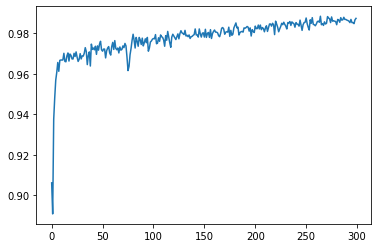

In [77]:
# plt.plot(hist['epoch'], hist['loss'])
plt.plot(hist['epoch'], hist['accuracy'])

In [27]:
model.fit(normed_train_data, train_label, epochs=200)

Train on 3806 samples
Epoch 1/200
3806/3806 [==============================] - 1s 273us/sample - loss: 0.4662 - mae: 0.5482 - mse: 0.4662 - accuracy: 0.4971
Epoch 2/200
3806/3806 [==============================] - 1s 139us/sample - loss: 0.3389 - mae: 0.5003 - mse: 0.3389 - accuracy: 0.5644
Epoch 3/200
3806/3806 [==============================] - 1s 140us/sample - loss: 0.4061 - mae: 0.4849 - mse: 0.4061 - accuracy: 0.5930
Epoch 4/200
3806/3806 [==============================] - 1s 134us/sample - loss: 0.2961 - mae: 0.4732 - mse: 0.2961 - accuracy: 0.6211
Epoch 5/200
3806/3806 [==============================] - 1s 136us/sample - loss: 0.2781 - mae: 0.4658 - mse: 0.2781 - accuracy: 0.6432
Epoch 6/200
3806/3806 [==============================] - 1s 132us/sample - loss: 0.2336 - mae: 0.4484 - mse: 0.2336 - accuracy: 0.6716
Epoch 7/200
3806/3806 [==============================] - 1s 165us/sample - loss: 0.2261 - mae: 0.4405 - mse: 0.2261 - accuracy: 0.6795
Epoch 8/200
3806/3806 [==========

3806/3806 [==============================] - 0s 83us/sample - loss: 0.1069 - mae: 0.2609 - mse: 0.1069 - accuracy: 0.8739
Epoch 61/200
3806/3806 [==============================] - 0s 71us/sample - loss: 0.1036 - mae: 0.2569 - mse: 0.1036 - accuracy: 0.8896
Epoch 62/200
3806/3806 [==============================] - 0s 82us/sample - loss: 0.0997 - mae: 0.2528 - mse: 0.0997 - accuracy: 0.8862
Epoch 63/200
3806/3806 [==============================] - 0s 93us/sample - loss: 0.1042 - mae: 0.2558 - mse: 0.1042 - accuracy: 0.8894
Epoch 64/200
3806/3806 [==============================] - 0s 119us/sample - loss: 0.1121 - mae: 0.2603 - mse: 0.1121 - accuracy: 0.8765
Epoch 65/200
3806/3806 [==============================] - 1s 255us/sample - loss: 0.1113 - mae: 0.2640 - mse: 0.1113 - accuracy: 0.8857
Epoch 66/200
3806/3806 [==============================] - 1s 241us/sample - loss: 0.1057 - mae: 0.2551 - mse: 0.1057 - accuracy: 0.8881
Epoch 67/200
3806/3806 [==============================] - 1s 249u

3806/3806 [==============================] - 0s 113us/sample - loss: 0.0619 - mae: 0.1874 - mse: 0.0619 - accuracy: 0.9580
Epoch 120/200
3806/3806 [==============================] - 1s 165us/sample - loss: 0.0595 - mae: 0.1838 - mse: 0.0595 - accuracy: 0.9574
Epoch 121/200
3806/3806 [==============================] - 0s 119us/sample - loss: 0.0557 - mae: 0.1763 - mse: 0.0557 - accuracy: 0.9643
Epoch 122/200
3806/3806 [==============================] - 1s 141us/sample - loss: 0.0549 - mae: 0.1751 - mse: 0.0549 - accuracy: 0.9632
Epoch 123/200
3806/3806 [==============================] - 1s 151us/sample - loss: 0.0512 - mae: 0.1691 - mse: 0.0512 - accuracy: 0.9658
Epoch 124/200
3806/3806 [==============================] - 1s 197us/sample - loss: 0.0506 - mae: 0.1661 - mse: 0.0506 - accuracy: 0.9661
Epoch 125/200
3806/3806 [==============================] - 1s 154us/sample - loss: 0.0524 - mae: 0.1700 - mse: 0.0524 - accuracy: 0.9664
Epoch 126/200
3806/3806 [==============================

3806/3806 [==============================] - 0s 80us/sample - loss: 0.0298 - mae: 0.1275 - mse: 0.0298 - accuracy: 0.9887
Epoch 180/200
3806/3806 [==============================] - 1s 161us/sample - loss: 0.0296 - mae: 0.1251 - mse: 0.0296 - accuracy: 0.9900
Epoch 181/200
3806/3806 [==============================] - 1s 166us/sample - loss: 0.0301 - mae: 0.1267 - mse: 0.0301 - accuracy: 0.9884
Epoch 182/200
3806/3806 [==============================] - 1s 181us/sample - loss: 0.0285 - mae: 0.1242 - mse: 0.0285 - accuracy: 0.9911
Epoch 183/200
3806/3806 [==============================] - 1s 206us/sample - loss: 0.0363 - mae: 0.1378 - mse: 0.0363 - accuracy: 0.9858
Epoch 184/200
3806/3806 [==============================] - 1s 202us/sample - loss: 0.0374 - mae: 0.1371 - mse: 0.0374 - accuracy: 0.9887
Epoch 185/200
3806/3806 [==============================] - 1s 212us/sample - loss: 0.0353 - mae: 0.1392 - mse: 0.0353 - accuracy: 0.9853
Epoch 186/200
3806/3806 [==============================]

In [83]:
results = model.evaluate(normed_test_data, test_label, batch_size=128)
print('test loss, test acc:', results)

1795/1795 [==============================] - 0s 15us/sample - loss: 303877.8161 - mae: 13.5796 - mse: 303877.7812 - accuracy: 0.6329
test loss, test acc: [303877.81612792925, 13.579606, 303877.78, 0.63286906]
